<h3>Introduction</h3>
The main idea of this notebook is to compare different methods of image upsampling. I am going to implement a SRCNN neural network and its faster version - FSRCNN in PyTorch.   

<h3>Libraries</h3>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [6]:
!mv /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
aliiihussain/social-media-viral-content-and-engagement-metrics     Social Media Viral Content & Engagement Metrics         70865  2026-01-18 12:14:36.423000              0         25  1.0              
thedrzee/e-commerce-business-analysis-20222024                     E-Commerce Business Analysis (2022–2024)                42375  2026-01-17 20:20:13.150000              0         23  0.9411765        
neurocipher/heartdisease                                           Heart Disease                                            3491  2025-12-11 15:29:14.327000           2114        341  1.0     

In [7]:
!kaggle datasets download andrewmvd/animal-faces

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 98% 679M/696M [00:07<00:00, 137MB/s]
100% 696M/696M [00:07<00:00, 92.7MB/s]


In [8]:
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

Imports

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
from os import path
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms.functional import to_pil_image
import math
import matplotlib.pyplot as plt
from math import sqrt, log10
import time

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Dataset

In [11]:
class CustomDataset(Dataset):
  def __init__(self, data_root, mode):
    super(Dataset, self).__init__()
    self.data_root = data_root
    self.data = []
    self.mode = mode  # "train" or "val"


  def __getitem__(self, idx):
    x, y = self.data[idx]
    return x, y


  def __len__(self):
    return len(self.data)


  def setup(self, pics_per_dir=50, downsample_ratio=2):
    for root, dirs, files in os.walk(self.data_root):
      for index, f in enumerate(files):
          if index < pics_per_dir and self.mode in path.join(root, f):  #we're takin' 50 (by default) pics of each animal type

            full_image = Image.open(path.join(root, f))
            width, height = full_image.size #image initial shape
            downsampled_image = full_image.resize((width // downsample_ratio, height // downsample_ratio))  #downsampling
            downsampled_image = downsampled_image.resize((height, width), Image.BICUBIC)  #resizing w/ bicubic interpolation
            fi_tensor = pil_to_tensor(full_image) / 255 #normalizing tensors to [0,1]
            di_tensor = pil_to_tensor(downsampled_image) / 255
            print(di_tensor.shape)
            print(fi_tensor.shape)
            self.data.append([di_tensor, fi_tensor])




In [12]:
train_dataset = CustomDataset("afhq", "train")
train_dataset.setup(100,4)
val_dataset = CustomDataset("afhq", "val")
val_dataset.setup(20,4)

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([

Example images

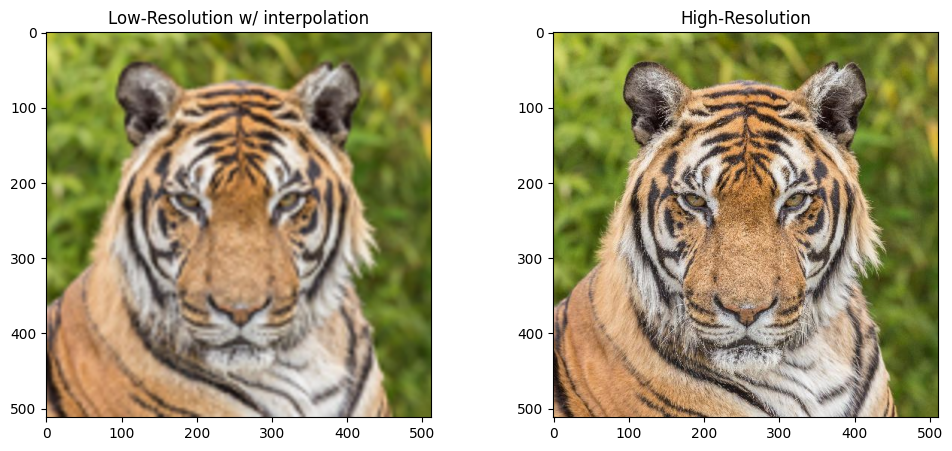

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Low-Resolution w/ interpolation")
plt.imshow(to_pil_image(train_dataset[0][0]))
plt.subplot(1,2,2)
plt.title("High-Resolution")
plt.imshow(to_pil_image(train_dataset[0][1]))

Loading data

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Peak Signal to Noise Ratio helper

In [15]:
def PSNR(original_image, reconstructed_image):
    mse = np.mean((original_image - reconstructed_image).detach().cpu().numpy() ** 2)
    if(mse == 0):
        return 100

    psnr = 20 * log10(255.0 / sqrt(mse))
    return psnr

Plotting helper

In [16]:
def plot_metrics(train_loss, val_loss, train_psnr, val_psnr, version):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, color='orange', label='Training loss')
    plt.plot(val_loss, color='red', label='Validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../content/{version}_loss.png')
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.plot(train_psnr, color='green', label='Training PSNR dB')
    plt.plot(val_psnr, color='blue', label='Validation PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR dB')
    plt.legend()
    plt.savefig(f'../content/{version}_psnr.png')
    plt.close()


SRCNN Architecture

In [17]:
class SRCNN(nn.Module):
  def __init__(self):
    super(SRCNN, self).__init__()

    self.feature_extraction = nn.Sequential(
        nn.Conv2d(3, 64, 9, 1, 4),
        nn.ReLU(True)
    )

    self.nl_mapping = self.map = nn.Sequential(
        nn.Conv2d(64, 32, 1, 1, 0),
        nn.ReLU(True)
    )

    self.reconstruction = nn.Conv2d(32, 3, 5, 1, 2)


  def forward(self, x):
    x = self.feature_extraction(x)
    x = self.nl_mapping(x)
    out = self.reconstruction(x)
    return out


FSRCNN Architecture

In [18]:
class FSRCNN(nn.Module):
   def __init__(self):
      super(FSRCNN, self).__init__()

      self.feature_extraction = nn.Sequential(
          nn.Conv2d(3, 56, 5, 1, 2),
          nn.PReLU()
      )

      self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, 1, 1, 0),
            nn.PReLU()
      )

      self.mapping = nn.Sequential(
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.PReLU()
      )

      self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, 1, 1, 0),
            nn.PReLU()
      )

      self.deconv = nn.ConvTranspose2d(56, 3, 9, 1, 4, 0)


   def forward(self, x):
      x = self.feature_extraction(x)
      x = self.shrinking(x)
      x = self.mapping(x)
      x = self.expanding(x)
      out = self.deconv(x)
      return out


Training & Validation

In [19]:
epochs = 50
lr = 0.001

In [20]:
#SRCNN model
model_srcnn = SRCNN().to(device)
optimizer_srcnn = torch.optim.Adam(model_srcnn.parameters(), lr)
loss_fn_srcnn = nn.MSELoss()



In [21]:
#FSRCNN model
model_fsrcnn = FSRCNN().to(device)
optimizer_fsrcnn = torch.optim.Adam(model_fsrcnn.parameters(), lr)
loss_fn_fsrcnn = nn.MSELoss()

In [22]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for image, label in dataloader:
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * image.size(0)
        psnr =  PSNR(label, output)
        running_psnr += psnr * image.size(0)

    final_loss = running_loss / len(dataloader.dataset)
    final_psnr = running_psnr / len(dataloader.dataset)
    return final_loss, final_psnr

In [23]:
def validate(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            loss = loss_fn(output, label)

            running_loss += loss.item() * image.size(0)
            psnr = PSNR(label, output)
            running_psnr += psnr * image.size(0)

    final_loss = running_loss / len(dataloader.dataset)
    final_psnr = running_psnr / len(dataloader.dataset)
    return final_loss, final_psnr

Runnin' the magic

In [24]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []

start = time.time()
def run(model, train_dataloader, val_dataloader, optimizer,loss_fn, version):
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1} / {epochs}")
      train_epoch_loss, train_epoch_psnr = train(model, train_dataloader,optimizer, loss_fn)
      val_epoch_loss, val_epoch_psnr = validate(model, val_dataloader,loss_fn)
      print(f"Training loss: {train_epoch_loss:.4f}")
      print(f"Validation loss: {val_epoch_loss:.4f}")
      print(f"Training PSNR: {train_epoch_psnr:.4f}")
      print(f"Validation PSNR: {val_epoch_psnr:.4f}")
      train_loss.append(train_epoch_loss)
      train_psnr.append(train_epoch_psnr)
      val_loss.append(val_epoch_loss)
      val_psnr.append(val_epoch_psnr)

      plot_metrics(train_loss, val_loss, train_psnr, val_psnr, version)

  end = time.time()
  print(f"Training time: {((end-start)/60):.4f} min")

SRCNN

In [ ]:
run(model_srcnn,train_dataloader, val_dataloader, optimizer_srcnn, loss_fn_srcnn, "srcnn")

Fast SRCNN

In [37]:
run(model_fsrcnn,train_dataloader, val_dataloader, optimizer_fsrcnn, loss_fn_fsrcnn, "fsrcnn")

Epoch 1 / 50
Training loss: 0.1378
Validation loss: 0.0787
Training PSNR: 57.4657
Validation PSNR: 59.2010
Epoch 2 / 50
Training loss: 0.0657
Validation loss: 0.0280
Training PSNR: 60.0289
Validation PSNR: 63.6733
Epoch 3 / 50
Training loss: 0.0174
Validation loss: 0.0122
Training PSNR: 65.9118
Validation PSNR: 67.2861
Epoch 4 / 50
Training loss: 0.0099
Validation loss: 0.0091
Training PSNR: 68.2392
Validation PSNR: 68.5619
Epoch 5 / 50
Training loss: 0.0086
Validation loss: 0.0085
Training PSNR: 68.8156
Validation PSNR: 68.8544
Epoch 6 / 50
Training loss: 0.0083
Validation loss: 0.0082
Training PSNR: 68.9989
Validation PSNR: 69.0211
Epoch 7 / 50
Training loss: 0.0080
Validation loss: 0.0081
Training PSNR: 69.1180
Validation PSNR: 69.0916
Epoch 8 / 50
Training loss: 0.0079
Validation loss: 0.0078
Training PSNR: 69.2281
Validation PSNR: 69.2431
Epoch 9 / 50
Training loss: 0.0076
Validation loss: 0.0076
Training PSNR: 69.3733
Validation PSNR: 69.3666
Epoch 10 / 50
Training loss: 0.0070
V

In [38]:
sample = val_dataset[0][0].to(device)

In [39]:
predict1_start = time.time()
predict1 = model_srcnn(sample)
predict1_end = time.time()

In [40]:
print(f"Prediction time:{predict1_end - predict1_start}")

Prediction time:0.0014379024505615234


In [41]:
predict2_start = time.time()
predict2 = model_fsrcnn(sample)
predict2_end = time.time()

torch.Size([3, 512, 512])


In [42]:
print(f"Prediction time:{predict2_end - predict2_start}")

Prediction time:0.0784461498260498


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Low-Resolution w/ interpolation")
plt.imshow(to_pil_image(val_dataset[0][0]))
plt.subplot(1,2,2)
plt.title("SRCNN Predict")
plt.imshow(to_pil_image(predict1))

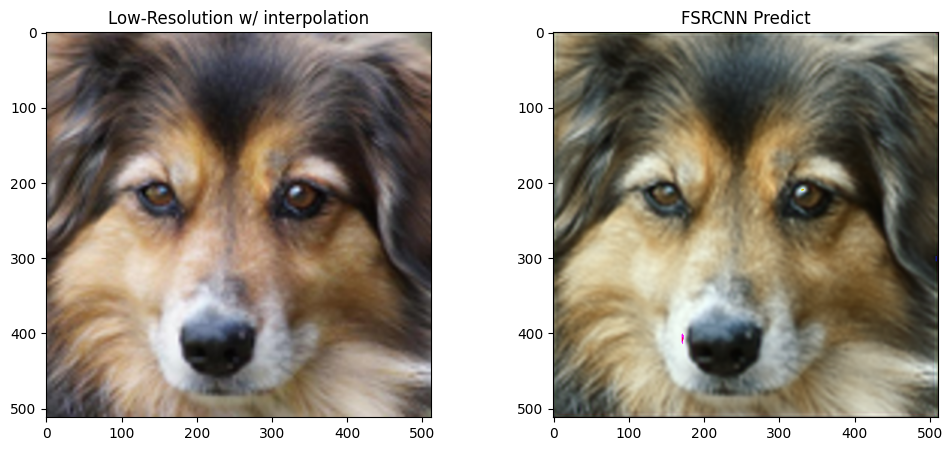

In [44]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Low-Resolution w/ interpolation")
plt.imshow(to_pil_image(val_dataset[0][0]))
plt.subplot(1,2,2)
plt.title("FSRCNN Predict")
plt.imshow(to_pil_image(predict2))